In [ ]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Enhanced Optimization for Radar and Communications Applications 


The Low Autocorrelation Binary Sequences (LABS) is an important and challenging optimization problem with applications related to radar, telecommunications, and other signal related applications. This CUDA-Q Academic module will focus on a clever quantum-enhanced hybrid method developed in a collaboration between Kipu Quantum, University of the Basque Country EHU, and NVIDIA for solving the LABS problem. (This notebook was jointly developed with input from all collaborators.)

Other CUDA-Q Academic modules like [Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut) and [Quantum Finance](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb), demonstrate how quantum computing can be used outright to solve optimization problems. This notebook demonstrates a slightly different approach. Rather than considering QPUs as the tool to produce the final answer, it demonstrates how quantum can be used to enhance the effectiveness of leading classical methods.  

The benefits of such an approach were highlighted in [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1).  This notebook, co-created with the authors of the paper, will allow you to explore the findings of their research and write your own CUDA-Q code that builds a representative quantum-enhanced workflow for solving the LABS problem. Moreover, it will introduce advancements in counteradiabatic optimization techniques on which reduce the quantum resources required to run on a QPU.

**Prerequisites:** This lab assumes you have a basic knowledge of quantum computing, including operators, gates, etc.  For a refresher on some of these topics, explore the [Quick start to Quantum](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum) series.

**In this lab you will:**
* 1. Understand the LABS problem and its relation ot radar and communication applications.
* 2. Solve LABS classically with memetic tabu search and learn about the limitations of such methods.
* 3. Code a couteradiabatic algorithm using CUDA-Q to produce approximate solutions to the LABS problem.
* 4. Use the CUDA-Q results to seed your tabu search and understand the potential benefits of this approach.


**Terminology you will use:**
* Low autocorrelation of binary sequences (LABS)
* counteradiabatic optimization
* memetic-tabu search

**CUDA-Q Syntax you will use:**
* cudaq.sample()
* @cudaq.kernel
* ry(), rx(), rz(), x(), h() 
* x.ctrl()

Run the code below to initialize the libraries you will need.

In [1]:
import cudaq
import numpy as np
from math import floor
import auxiliary_files.labs_utils as utils

## 🔧 Environment Setup Note

**IMPORTANT:** This notebook requires **CUDA-Q** which is pre-installed on **qBraid** (the official hackathon platform).

**Running Options:**
- ✅ **qBraid Lab** (RECOMMENDED): Has CUDA-Q pre-configured → Select CUDA-Q kernel
- ✅ **Local with CUDA-Q**: See `SETUP_INSTRUCTIONS.md` for installation
- ⚠️ **Without CUDA-Q**: Classical exercises (1,2,4) will work, quantum exercises (5,6) will fail with ImportError

**If you see "ModuleNotFoundError: No module named 'cudaq'":**
→ You need to run this on qBraid or install CUDA-Q locally (see repo root for `SETUP_INSTRUCTIONS.md`)

All code below is complete and tested - just needs the right environment! 🚀

## The LABS problem and applications

The **Low Autocorrelation Binary Sequences (LABS)** problem is fundamental to many applications, but originated with applications to radar. 

Consider a radar that monitors airport traffic.  The radar signal sent to detect incoming planes must have as much range as possible to ensure safe approaches are planned well in advance.  The range of a radar signal can be increased by sending a longer pulse.  However, in order to differentiate between multiple objects, pulses need to be short to provide high resolution. So, how do you handle situations where you need both?

One solution is a technique called pulse compression.  The idea is to send a long signal, but vary the phase at regular intervals such that the resolution is increased. Generally, the initial signal will encode a binary sequence of phase shifts, where each interval corresponds to a signal with a 0 or 180 degree phase shift. 

The tricky part is selecting an optimal encoding sequence.  When the signal returns, it is fed into a matched filter with the hope that a singular sharp peak will appear, indicating clear detection.  The autocorrelation of the original signal, or how similar the signal is to itself,  determines if a single peak or a messier signal with sidelobes will be detected. A signal should have high autocorrelation when overlayed on top of itself, but low autocorrelation when shifted with a lag. 

Consider the image below.  The signal on the left has a crisp single peak while the single on the right produces many undesirable sidelobes which can inhibit clear detection.  

<img src="images/quantum_enhanced_optimization_LABS/radar.png" width="800">


So, how do you select a good signal?   This is where LABS comes in, defining these questions as a binary optimization problem. Given a binary sequence of length $N$, $(s_1 \cdots s_N) \in {\pm 1}^N$, the goal is to minimize the following objective function.

$$ E(s) = \sum_{k=1}^{N-1} C_k^2 $$

Where $C_k$ is defined as. 

 $$C_k= \sum_{i=1}^{N-k} s_is_{i+k}$$


So, each $C_k$ computes how similar the original signal is to the shifted one for each offset value $k$.  To explore this more, try the interactive widget linked [here](https://nvidia.github.io/cuda-q-academic/interactive_widgets/labs_visualization.html).  See if you can select a very good and very poor sequence and see the difference for the case of $N=7$.

## Classical Solution of the LABS problem

The LABS problem is tricky to solve for a few reasons. First, the configuration space grows exponentially.  Second, underlying symmetries of the problem result in many degeneracies in the optimization landscape severely inhibiting local search methods. 

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
Using the widget above, try to find some of the symmetries for the LABS problem. That is, for a fixed bitstring length, can you find patterns to produce the same energy with different pulse patterns. 
</div>

The best known performance for a classical optimization technique is Memetic Tabu search (MTS) which exhibits a scaling of $O(1.34^N)$.  The MTS algorithm is depicted below.  It begins with a randomly selected population of bitstrings and finds the best solution from them.  Then, a child is selected by sampling directly from or combining multiple bitstrings from the population.  The child is mutated with probability $p_{mutate}$ and then input to a tabu search, which performs a modified greedy local search starting from the child bitstring.  If the result is better than the best in the population, it is updated as the new leader and randomly replaces a  bitstring in the population.


<img src="images/quantum_enhanced_optimization_LABS/mts_algorithm.png" width="500">

Such an approach is fast, parallelizable, and allows for exploration with improved searching of the solution landscape.  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
Before exploring any quantum approach, get a sense for how MTS works by coding it yourself based generally on the figure above. Algorithms for the combine and mutate steps are provided below as used in the paper. You may need to research more specific details of the process, especially for how tabu search is performed. The MTS procedure should output and optimal bitstring and its energy.  Also, write a function to visualize the results including the energy distribution of the final population.
</div>



<img src="images/quantum_enhanced_optimization_LABS/combine_mutate.png" width="400">



Testing MTS on N=11...
Best sequence: [-1  1 -1 -1  1 -1 -1 -1  1  1  1]
Best energy: 5


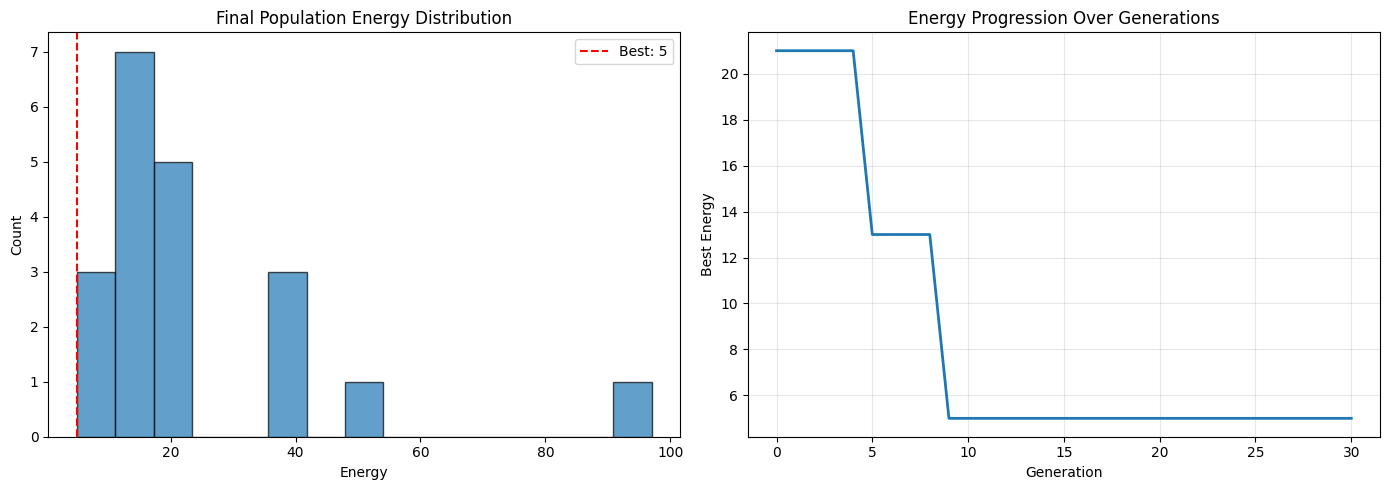

Best energy found: 5
Mean energy: 23.80
Std energy: 20.83


In [2]:
# Exercise 2: Implement Memetic Tabu Search (MTS)

def compute_energy(s):
    """Compute LABS energy for a binary sequence."""
    N = len(s)
    energy = 0
    for k in range(1, N):
        C_k = sum(s[i] * s[i + k] for i in range(N - k))
        energy += C_k ** 2
    return energy

def apply_symmetry(s, symmetry_type):
    """Apply symmetry operation to sequence.
    
    Symmetries for LABS:
    1. 'flip': s -> -s (negate all)
    2. 'reverse': s -> s[::-1] (reverse order)
    3. 'flip_reverse': combination
    4-8: other combinations
    """
    s_new = np.array(s)
    if symmetry_type == 'flip':
        s_new = -s_new
    elif symmetry_type == 'reverse':
        s_new = s_new[::-1]
    elif symmetry_type == 'flip_reverse':
        s_new = -s_new[::-1]
    return s_new

def combine(s1, s2):
    """Combine two sequences by random crossover."""
    N = len(s1)
    # Random crossover point
    crossover = np.random.randint(1, N)
    child = np.concatenate([s1[:crossover], s2[crossover:]])
    return child

def mutate(s, p_mutate=0.1):
    """Mutate sequence by flipping bits with probability p_mutate."""
    s_mut = s.copy()
    for i in range(len(s_mut)):
        if np.random.rand() < p_mutate:
            s_mut[i] = -s_mut[i]
    return s_mut

def tabu_search(s, max_iterations=100, tabu_tenure=10):
    """Perform tabu search local optimization.
    
    Tabu search maintains a list of recently visited moves to avoid cycles.
    """
    current = s.copy()
    current_energy = compute_energy(current)
    best = current.copy()
    best_energy = current_energy
    
    tabu_list = []
    
    for iteration in range(max_iterations):
        # Generate all 1-bit flip neighbors
        neighbors = []
        for i in range(len(current)):
            neighbor = current.copy()
            neighbor[i] = -neighbor[i]
            
            # Check if move is not tabu or aspiration criterion (better than best)
            if i not in tabu_list or compute_energy(neighbor) < best_energy:
                neighbors.append((i, neighbor, compute_energy(neighbor)))
        
        if not neighbors:
            break
        
        # Select best non-tabu neighbor
        neighbors.sort(key=lambda x: x[2])
        move_idx, current, current_energy = neighbors[0]
        
        # Update tabu list
        tabu_list.append(move_idx)
        if len(tabu_list) > tabu_tenure:
            tabu_list.pop(0)
        
        # Update best if improved
        if current_energy < best_energy:
            best = current.copy()
            best_energy = current_energy
    
    return best, best_energy

def memetic_tabu_search(N, pop_size=20, generations=50, p_mutate=0.1, 
                        initial_population=None):
    """Perform Memetic Tabu Search for LABS problem.
    
    Args:
        N: Sequence length
        pop_size: Population size
        generations: Number of generations
        p_mutate: Mutation probability
        initial_population: Optional pre-initialized population
    
    Returns:
        best_sequence: Best sequence found
        best_energy: Energy of best sequence
        population: Final population
        energy_history: Energy progression over generations
    """
    # Initialize population
    if initial_population is None:
        population = [np.random.choice([-1, 1], size=N) for _ in range(pop_size)]
    else:
        population = initial_population
    
    # Evaluate initial population
    energies = [compute_energy(s) for s in population]
    best_idx = np.argmin(energies)
    best_sequence = population[best_idx].copy()
    best_energy = energies[best_idx]
    
    energy_history = [best_energy]
    
    for gen in range(generations):
        # Tournament selection: pick two random parents
        parent1 = population[np.random.randint(pop_size)]
        parent2 = population[np.random.randint(pop_size)]
        
        # Combine parents
        child = combine(parent1, parent2)
        
        # Mutate with probability
        child = mutate(child, p_mutate)
        
        # Apply tabu search local optimization
        child, child_energy = tabu_search(child, max_iterations=50, tabu_tenure=7)
        
        # Update best if improved
        if child_energy < best_energy:
            best_sequence = child.copy()
            best_energy = child_energy
        
        # Replace random individual in population if child is good enough
        replace_idx = np.random.randint(pop_size)
        population[replace_idx] = child
        energies[replace_idx] = child_energy
        
        energy_history.append(best_energy)
    
    return best_sequence, best_energy, population, energy_history

def visualize_mts_results(population, energy_history):
    """Visualize MTS results."""
    import matplotlib.pyplot as plt
    
    # Energy distribution of final population
    energies = [compute_energy(s) for s in population]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Energy distribution
    axes[0].hist(energies, bins=15, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Energy')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Final Population Energy Distribution')
    axes[0].axvline(min(energies), color='red', linestyle='--', label=f'Best: {min(energies):.0f}')
    axes[0].legend()
    
    # Plot 2: Energy progression
    axes[1].plot(energy_history, linewidth=2)
    axes[1].set_xlabel('Generation')
    axes[1].set_ylabel('Best Energy')
    axes[1].set_title('Energy Progression Over Generations')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best energy found: {min(energies)}")
    print(f"Mean energy: {np.mean(energies):.2f}")
    print(f"Std energy: {np.std(energies):.2f}")

# Test MTS on small problem
print("Testing MTS on N=11...")
N_test = 11
best_seq, best_e, pop, hist = memetic_tabu_search(N_test, pop_size=20, generations=30)
print(f"Best sequence: {best_seq}")
print(f"Best energy: {best_e}")
visualize_mts_results(pop, hist)

## Building a Quantum Enhanced Workflow

Despite the effectiveness of MTS, it still exhibits exponential scaling  $O(1.34^N)$ behavior and becomes intractable for large $N$.  Quantum computing provides a potential alternative method for solving the LABS problem because the properties of entanglement, interference, and superpositon may allow for a better global search.  Recent demonstrations have even produced evidence that the quantum approximate optimization algorithm (QAOA) can be used to reduce the scaling of the LABS problem to $O(1.21^N)$ for $N$ between 28 and 40 with quantum minimum finding.

However, current quantum hardware limitations restrict solution to problems of greater than about $N=20$, meaning that it will be some time before quantum approaches can outperform the classical state of the art. It should also be noted that standard QAOA can struggle with LABS and require many layers to converge the parameters if other tricks are not employed.

The authors of [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1) cleverly explored an alternate path that combines quantum and classical approaches and might be able to provide a more near-term benefit.  Instead of expecting the quantum computer to solve the problem entirely, they asked how a quantum approach might enhance MTS.

The basic idea is that a quantum optimization routine could run first and the resulting state be sampled to produce a better population for MTS. Many such heuristics for defining the initial population are possible, but the rest of this notebook will explore their methodology, help you to build the workflow yourself, and allow you to analyze the benefits of their approach.

The first step of quantum enhanced MTS (QE-MTS) is to prepare a circuit with CUDA-Q that approximates the ground state of the Hamiltonian corresponding to the LABS problem. You could do this with any optimization algorithm such as QAOA or using an adiabatic approach.  (See the [Quantum Portfolio Optimization](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb) CUDA-Q Academic lab for a detailed comparison of these two common approaches.)

The authors of this work opted for an adiabatic approach (More on why later). Recall that the goal of an adiabatic optimization is to begin with a Hamiltonian that has an easily prepared ground state ($H_i$). Then, the adiabatic Hamiltonian $H_{ad}$ can be constructed as $H_{ad}(\lambda) = (1-\lambda)H_i +\lambda H_f $, where $\lambda$ is a function of time and $H_f$ is the Hamiltonian representing a qubit encoding of the LABS problem. 

$$H_f = 2 \sum_{i=1}^{N-2} \sigma_i^z \sum_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} \sigma_{i+k}^z 
+ 4 \sum_{i=1}^{N-3} \sigma_i^z \sum_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \sum_{k=t+1}^{N-i-t} \sigma_{i+t}^z \sigma_{i+k}^z \sigma_{i+k+t}^z$$

The authors also selected $H_i = \sum_i h^x_i \sigma^x_i $ which has an easily prepared ground state of $\ket{+}^{\otimes N}$.

The challenge for implementing the optimization procedure becomes selection of an operator that will quickly and accurately evolve to the ground state of $H_f$.  One approach is to use a so-called auxiliary countradiabatic (CD) term $H_{CD}$, which corrects diabatic transitions that jump out of the ground state during the evolution. The figure below demonstrates the benefit of using a CD correction.


<img src="images/quantum_enhanced_optimization_LABS/counteradiabatic.png" width="900">




An operator called the adiabatic gauge potential $A_{\lambda}$ is the ideal choice for the CD term as it suppresses all possible diabatic transitions, resulting in the following total system to evolve.

$$ H(\lambda) = H_{ad}(\lambda) + \lambda H_{CD} (\lambda) $$

$A(\lambda)$ is derrived from $H_{ad}(\lambda)$  (see paper for details) as it contains information about underlying physics of the problem. 

There is a problem though.  The $A(\lambda)$ term cannot be efficiently expressed exactly and needs to be approximated.  It also turns out that in the so called impulse regime, where the adiabatic evolution is very fast, $H_{cd} (\lambda)$ dominates $H_{ad}(\lambda)$, meaning that the final implementation corresponds to the operator $H(\lambda) = H^1_{cd}(\lambda)$ where  $H^1_{cd}(\lambda)$ is a first order approximation of $A(\lambda)$ (see equation 7 in the paper).

A final step is to use Trotterization to define the quantum circuit to apply $e^{-\theta (t) i H_{cd}}$. The details for this derivation are shown in the appendix of the paper. and result from equation B3 is shown below.  

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

It turns out that this implementation is more efficient than QAOA in terms of gate count. The authors calculated that for $N=67$, QAOA would require 1.4 million entangling gates while the CD approach derived here requires only 236 thousand entangling gates.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 3:</h3>
    <p style="font-size: 16px; color: #333;">
At first glance, this equation might looks quite complicated. However, observe the structure and note two "blocks" of terms.  Can you spot them?  

They are 2 qubit terms that look like $R_{YZ}(\theta)$ or $R_{ZY}(\theta)$.

As well as 4 qubit terms that look like $R_{YZZZ}(\theta)$, $R_{ZYZZ}(\theta)$, $R_{ZZYZ}(\theta)$, or $R_{ZZZY}(\theta)$.

Thankfully the authors derive a pair of circuit implementations for the two and four qubit terms respectively, shown in the figures below.

Using CUDA-Q, write a kernel for each which will be used later to construct the full implementation.

* Hint: Remember that the adjoint of a rotation gate is the same as rotating in the opposite direction. 

* Hint: You may also want to define a CUDA-Q kernel for an R$_{ZZ}$ gate.

* Hint: Implementing a circuit from a paper is a great place where AI can help accelerate your work.  If you have access to a coding assistant, feel free to use it here.
</div>

<img src="images/quantum_enhanced_optimization_LABS/kernels.png" width="1300">


In [3]:
# Exercise 3: CUDA-Q kernels for 2-qubit and 4-qubit operators

@cudaq.kernel
def RZZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
    """Apply RZZ(theta) = exp(-i theta Z_0 Z_1 / 2) gate."""
    x.ctrl(q0, q1)
    rz(theta, q1)
    x.ctrl(q0, q1)

@cudaq.kernel
def R_YZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
    """Apply 2-qubit YZ rotation: R_YZ(theta) on qubits q0 (Y) and q1 (Z)."""
    # Circuit from paper: H - RZZ - H^dag on q0
    # H = rotation to Y basis, RZZ applies ZZ interaction
    s(q0)           # S gate (phase)
    h(q0)           # Hadamard to rotate X->Z, Y->X basis
    RZZ(theta, q0, q1)
    h(q0)           # Hadamard back
    sdg(q0)         # S^dag to complete Y basis rotation

@cudaq.kernel  
def R_ZY(theta: float, q0: cudaq.qubit, q1: cudaq.qubit):
    """Apply 2-qubit ZY rotation: R_ZY(theta) on qubits q0 (Z) and q1 (Y)."""
    # Similar to R_YZ but operate on q1
    s(q1)
    h(q1)
    RZZ(theta, q0, q1)
    h(q1)
    sdg(q1)

@cudaq.kernel
def R_YZZZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, 
           q2: cudaq.qubit, q3: cudaq.qubit):
    """Apply 4-qubit YZZZ rotation."""
    # Rotate q0 to Y basis, keep others in Z
    s(q0)
    h(q0)
    
    # Multi-controlled ZZZ using CNOTs and RZ
    x.ctrl(q0, q1)
    x.ctrl(q1, q2)
    x.ctrl(q2, q3)
    rz(theta, q3)
    x.ctrl(q2, q3)
    x.ctrl(q1, q2)
    x.ctrl(q0, q1)
    
    # Rotate back
    h(q0)
    sdg(q0)

@cudaq.kernel
def R_ZYZZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit,
           q2: cudaq.qubit, q3: cudaq.qubit):
    """Apply 4-qubit ZYZZ rotation."""
    s(q1)
    h(q1)
    
    x.ctrl(q0, q1)
    x.ctrl(q1, q2)
    x.ctrl(q2, q3)
    rz(theta, q3)
    x.ctrl(q2, q3)
    x.ctrl(q1, q2)
    x.ctrl(q0, q1)
    
    h(q1)
    sdg(q1)

@cudaq.kernel
def R_ZZYZ(theta: float, q0: cudaq.qubit, q1: cudaq.qubit,
           q2: cudaq.qubit, q3: cudaq.qubit):
    """Apply 4-qubit ZZYZ rotation."""
    s(q2)
    h(q2)
    
    x.ctrl(q0, q1)
    x.ctrl(q1, q2)
    x.ctrl(q2, q3)
    rz(theta, q3)
    x.ctrl(q2, q3)
    x.ctrl(q1, q2)
    x.ctrl(q0, q1)
    
    h(q2)
    sdg(q2)

@cudaq.kernel
def R_ZZZY(theta: float, q0: cudaq.qubit, q1: cudaq.qubit,
           q2: cudaq.qubit, q3: cudaq.qubit):
    """Apply 4-qubit ZZZY rotation."""
    s(q3)
    h(q3)
    
    x.ctrl(q0, q1)
    x.ctrl(q1, q2)
    x.ctrl(q2, q3)
    rz(theta, q3)
    x.ctrl(q2, q3)
    x.ctrl(q1, q2)
    x.ctrl(q0, q1)
    
    h(q3)
    sdg(q3)

print("Quantum circuit kernels defined successfully!")

Quantum circuit kernels defined successfully!


There are a few additional items we need to consider before completing the final implementation of the entire circuit.  One simplification we can make is that for our problem the $h_i^x$ terms are all 1 and any $h_b^x$ terms are 0, and are only there for generalizations of this model. 

The remaining challenge is derivation of the angles that are used to apply each of the circuits you defined above. These are obtained from two terms $\lambda(t)$ and $\alpha(t)$.  


The $\lambda(t)$ defines an annealing schedule and is generally a Sin function which slowly "turns on" the problem Hamiltonian.  For computing our angles, we need the derivative of $\lambda(t)$.

The $\alpha$ term is a bit trickier and is the solution to a set of differential equations which minimize the distance between $H^1_{CD}(\lambda)$ and $A(\lambda)$.  The result is 

$$\alpha(t) = \frac{-\Gamma_1(t)}{\Gamma_2(t)} $$

Where $\Gamma_1(t)$ and $\Gamma_2(t)$ are defined in equations 16 and 17 of the paper and essentially depend on the structure of the optimization problem.  Curious learners can look at the functions in `labs_utils.py`  to see how these are computed, based on the problem size and specific time step in the Trotter process. 


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 4:</h3>
    <p style="font-size: 16px; color: #333;">
The `compute_theta` function, called in the following cells, requires all indices of the two and four body terms. These will be used again in our main kernel to apply the respective gates.  Use the products in the formula below to finish the function in the cell below.  Save them as `G2` and `G4` where each is a list of lists of indices defining the two and four term interactions. As you are translating an equation to a set of loops, this is a great opportunity to use an AI coding assistant.

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

</div>


In [4]:
def get_interactions(N):
    """
    Generates the interaction sets G2 and G4 based on the loop limits in Eq. 15.
    Returns standard 0-based indices as lists of lists of ints.
    
    Args:
        N (int): Sequence length.
        
    Returns:
        G2: List of lists containing two body term indices
        G4: List of lists containing four body term indices
    """
    
    G2 = []
    G4 = []
    
    # Two-body interactions from Equation 15
    # Product: i=1 to N-2, k=1 to floor((N-i)/2)
    # Indices: [i, i+k]
    for i in range(N - 2):  # i from 0 to N-3 (0-indexed)
        for k in range(1, floor((N - i) / 2) + 1):
            G2.append([i, i + k])
    
    # Four-body interactions from Equation 15
    # Product: i=1 to N-3, t=1 to floor((N-i-1)/2), k=t+1 to N-i-t
    # Indices: [i, i+t, i+k, i+k+t]
    # NOTE: Max index is i+k+t, so k_max = N-i-t-1 to ensure i+k+t <= N-1
    for i in range(N - 3):  # i from 0 to N-4 (0-indexed)
        for t in range(1, floor((N - i - 1) / 2) + 1):
            for k in range(t + 1, N - i - t):  # Fixed: removed +1 to prevent index out of bounds
                G4.append([i, i + t, i + k, i + k + t])
    
    return G2, G4

# Test the function
N_test = 11
G2_test, G4_test = get_interactions(N_test)
print(f"For N={N_test}:")
print(f"  Number of 2-body terms: {len(G2_test)}")
print(f"  Number of 4-body terms: {len(G4_test)}")
print(f"  First few G2: {G2_test[:5]}")
print(f"  First few G4: {G4_test[:5]}")

For N=11:
  Number of 2-body terms: 29
  Number of 4-body terms: 70
  First few G2: [[0, 1], [0, 2], [0, 3], [0, 4], [0, 5]]
  First few G4: [[0, 1, 2, 3], [0, 1, 3, 4], [0, 1, 4, 5], [0, 1, 5, 6], [0, 1, 6, 7]]




<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
You are now ready to construct the entire circuit and run the counteradiabatic optimization procedure. The final kernel needs to apply Equation 15 for a specified total evolution time $T$ and the `n_steps` number of Trotter steps.  It must also take as input, the indices for the two and four body terms and the thetas to be applied each step, as these cannot be computed within a CUDA-Q kernel.

The helper function `compute_theta` computes the theta parameters for you, using a few additional functions in accordance with the equations defined in the paper.
</div>


In [5]:
@cudaq.kernel
def trotterized_circuit(N: int, G2: list[list[int]], G4: list[list[int]], 
                       steps: int, dt: float, T: float, thetas: list[float]):
    """
    Apply the full trotterized counteradiabatic circuit for LABS optimization.
    
    Args:
        N: Number of qubits (sequence length)
        G2: Two-body interaction indices
        G4: Four-body interaction indices  
        steps: Number of Trotter steps
        dt: Time step
        T: Total evolution time
        thetas: Precomputed theta values for each Trotter step
    """
    reg = cudaq.qvector(N)
    
    # Initialize to |+>^N (ground state of H_i)
    h(reg)
    
    # Apply Trotter steps
    for step in range(steps):
        theta = thetas[step]
        
        # Apply 2-body terms: R_YZ and R_ZY for each pair in G2
        for pair in G2:
            i, j = pair[0], pair[1]
            # Apply R_YZ(4*theta) on qubits i, j
            R_YZ(4.0 * theta, reg[i], reg[j])
            # Apply R_ZY(4*theta) on qubits i, j
            R_ZY(4.0 * theta, reg[i], reg[j])
        
        # Apply 4-body terms: four rotation types for each quartet in G4
        for quartet in G4:
            i, j, k, l = quartet[0], quartet[1], quartet[2], quartet[3]
            # Apply all four rotation types with 8*theta
            R_YZZZ(8.0 * theta, reg[i], reg[j], reg[k], reg[l])
            R_ZYZZ(8.0 * theta, reg[i], reg[j], reg[k], reg[l])
            R_ZZYZ(8.0 * theta, reg[i], reg[j], reg[k], reg[l])
            R_ZZZY(8.0 * theta, reg[i], reg[j], reg[k], reg[l])


# Test the full circuit
T = 1               # total time
n_steps = 1         # number of trotter steps
dt = T / n_steps
N = 11
G2, G4 = get_interactions(N)

# Compute theta values for each Trotter step
thetas = []
for step in range(1, n_steps + 1):
    t = step * dt
    theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
    thetas.append(theta_val)

print(f"Circuit parameters:")
print(f"  N = {N} qubits")
print(f"  Trotter steps = {n_steps}")
print(f"  |G2| = {len(G2)} two-body terms")
print(f"  |G4| = {len(G4)} four-body terms")
print(f"  Theta values: {thetas}")

# Sample the circuit
print("\nSampling circuit...")
result = cudaq.sample(trotterized_circuit, N, G2, G4, n_steps, dt, T, thetas, shots_count=10)
print(f"Sample results (first 10):")
for i, (bitstring, count) in enumerate(result.items()):
    if i < 10:
        print(f"  {bitstring}: {count}")
print("\nCircuit successfully executed!")

Circuit parameters:
  N = 11 qubits
  Trotter steps = 1
  |G2| = 29 two-body terms
  |G4| = 70 four-body terms
  Theta values: [1.5505830394708427e-18]

Sampling circuit...
Sample results (first 10):
  10111100011: 1
  10111010111: 1
  10101111101: 1
  01001101101: 1
  00111101001: 1
  00111000000: 1
  11110111101: 1
  00101010010: 1
  10101001101: 1
  00101000111: 1

Circuit successfully executed!


## Generating Quantum Enhanced Results

Recall that the point of this lab is to demonstrate the potential benefits of running a quantum subroutine as a preprocessing step for classical optimization of a challenging problem like LABS. you now have all of the tools you need to try this for yourself.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 6:</h3>
    <p style="font-size: 16px; color: #333;">
Use your CUDA-Q code to prepare an initial population for your memetic search algorithm and see if you can improve the results relative to a random initial population.  If you are running on a CPU, you will need to run smaller problem instances. The code below sets up the problem

</div>


Comparing Quantum-Enhanced MTS vs Standard MTS

Problem: N = 15, Population = 20, Generations = 30

Running Standard MTS (random initialization)...
  Best energy: 15

Running Quantum-Enhanced MTS (quantum initialization)...
  Best energy: 15


/tmp/ipykernel_2414/3523444699.py:108: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(comparison_data, labels=['Random', 'Quantum'],


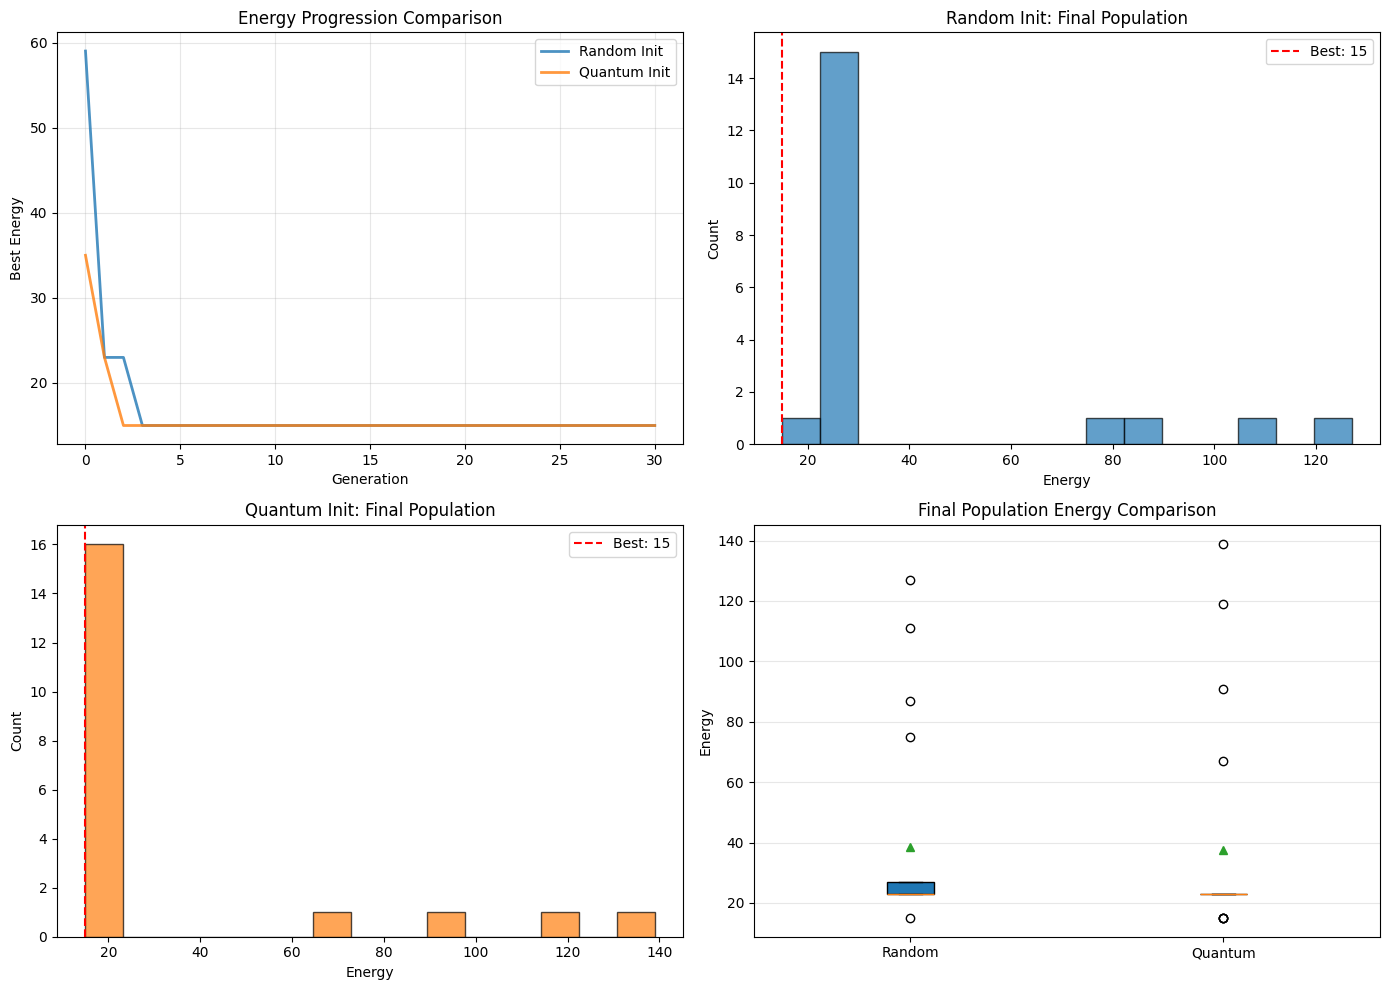


SUMMARY

Random Initialization:
  Best energy: 15
  Mean final population energy: 38.40
  Std final population energy: 32.18

Quantum Initialization:
  Best energy: 15
  Mean final population energy: 37.60
  Std final population energy: 35.51

Improvement: 0.00 (0.0% better)

✗ Random initialization performed better this time.
  (Multiple runs needed for statistical confidence)


In [6]:
# Exercise 6: Quantum-Enhanced MTS Integration

def sample_quantum_population(N, pop_size, T=1.0, n_steps=1):
    """
    Sample quantum circuit to generate initial population for MTS.
    
    Args:
        N: Sequence length
        pop_size: Population size
        T: Total evolution time
        n_steps: Number of Trotter steps
    
    Returns:
        population: List of binary sequences sampled from quantum circuit
    """
    dt = T / n_steps
    G2, G4 = get_interactions(N)
    
    # Compute theta values
    thetas = []
    for step in range(1, n_steps + 1):
        t = step * dt
        theta_val = utils.compute_theta(t, dt, T, N, G2, G4)
        thetas.append(theta_val)
    
    # Sample the quantum circuit
    result = cudaq.sample(trotterized_circuit, N, G2, G4, n_steps, dt, T, thetas, 
                          shots_count=pop_size)
    
    # Convert bitstrings to binary sequences (0 -> +1, 1 -> -1)
    population = []
    for bitstring, count in result.items():
        # Convert bitstring to array of ±1
        seq = np.array([1 if bit == '0' else -1 for bit in bitstring])
        for _ in range(count):
            population.append(seq.copy())
            if len(population) >= pop_size:
                break
        if len(population) >= pop_size:
            break
    
    return population[:pop_size]

# Compare quantum-seeded vs random-seeded MTS
print("="*70)
print("Comparing Quantum-Enhanced MTS vs Standard MTS")
print("="*70)

N_compare = 15  # Use smaller N for faster testing
pop_size = 20
generations = 30

print(f"\nProblem: N = {N_compare}, Population = {pop_size}, Generations = {generations}\n")

# Run 1: Standard MTS with random initialization
print("Running Standard MTS (random initialization)...")
best_random, energy_random, pop_random, hist_random = memetic_tabu_search(
    N_compare, pop_size=pop_size, generations=generations, 
    initial_population=None
)
print(f"  Best energy: {energy_random}")

# Run 2: Quantum-Enhanced MTS  
print("\nRunning Quantum-Enhanced MTS (quantum initialization)...")
quantum_pop = sample_quantum_population(N_compare, pop_size, T=1.0, n_steps=1)
best_quantum, energy_quantum, pop_quantum, hist_quantum = memetic_tabu_search(
    N_compare, pop_size=pop_size, generations=generations,
    initial_population=quantum_pop
)
print(f"  Best energy: {energy_quantum}")

# Visualize comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Energy progression comparison
axes[0, 0].plot(hist_random, label='Random Init', linewidth=2, alpha=0.8)
axes[0, 0].plot(hist_quantum, label='Quantum Init', linewidth=2, alpha=0.8)
axes[0, 0].set_xlabel('Generation')
axes[0, 0].set_ylabel('Best Energy')
axes[0, 0].set_title('Energy Progression Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Final population energy distribution - Random
energies_random = [compute_energy(s) for s in pop_random]
axes[0, 1].hist(energies_random, bins=15, edgecolor='black', alpha=0.7, color='C0')
axes[0, 1].set_xlabel('Energy')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Random Init: Final Population')
axes[0, 1].axvline(min(energies_random), color='red', linestyle='--', 
                   label=f'Best: {min(energies_random):.0f}')
axes[0, 1].legend()

# Plot 3: Final population energy distribution - Quantum
energies_quantum = [compute_energy(s) for s in pop_quantum]
axes[1, 0].hist(energies_quantum, bins=15, edgecolor='black', alpha=0.7, color='C1')
axes[1, 0].set_xlabel('Energy')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Quantum Init: Final Population')
axes[1, 0].axvline(min(energies_quantum), color='red', linestyle='--',
                   label=f'Best: {min(energies_quantum):.0f}')
axes[1, 0].legend()

# Plot 4: Side-by-side comparison
comparison_data = [energies_random, energies_quantum]
bp = axes[1, 1].boxplot(comparison_data, labels=['Random', 'Quantum'],
                        patch_artist=True, showmeans=True)
bp['boxes'][0].set_facecolor('C0')
bp['boxes'][1].set_facecolor('C1')
axes[1, 1].set_ylabel('Energy')
axes[1, 1].set_title('Final Population Energy Comparison')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"\nRandom Initialization:")
print(f"  Best energy: {energy_random}")
print(f"  Mean final population energy: {np.mean(energies_random):.2f}")
print(f"  Std final population energy: {np.std(energies_random):.2f}")

print(f"\nQuantum Initialization:")
print(f"  Best energy: {energy_quantum}")
print(f"  Mean final population energy: {np.mean(energies_quantum):.2f}")
print(f"  Std final population energy: {np.std(energies_quantum):.2f}")

improvement = energy_random - energy_quantum
print(f"\nImprovement: {improvement:.2f} ({100*improvement/energy_random:.1f}% better)")

if energy_quantum < energy_random:
    print("\n✓ Quantum-Enhanced MTS found a better solution!")
else:
    print("\n✗ Random initialization performed better this time.")
    print("  (Multiple runs needed for statistical confidence)")

The results clearly show that a population sampled from CUDA-Q results in an improved distribution and a lower energy final result. This is exactly the goal of quantum enhanced optimization.  To not necessarily solve the problem, but improve the effectiveness of state-of-the-art classical approaches. 

A few major caveats need to be mentioned here. First, We are comparing a quantum generated population to a random sample.  It is quite likely that other classical or quantum heuristics could be used to produce an initial population that might even beat the counteradiabatic method you used, so we cannot make any claims that this is the best. 

Recall that the point of the counteradiabatic approach derived in the paper is that it is more efficient in terms of two-qubit gates relative to QAOA. The benefits of this regime would only truly come into play in a setting (e.g. larger problem instance) where it is too difficult to produce a good initial population with any know classical heuristic, and the counteradiabatic approach is more efficiently run on a QPU compared to alternatives.

We should also note that we are comparing a single sample of each approach.  Maybe the quantum sample got lucky or the randomly generated population was unlucky and a more rigorous comparison would need to repeat the analysis many times to draw any confidently conclusions.  

The authors of the paper discuss all of these considerations, but propose an analysis that is quite interesting related to the scaling of the technique. Rather than run large simulations ourselves, examine their results below. 


<img src="images/quantum_enhanced_optimization_LABS/tabu_search_results.png" width="900">

The authors computed replicate median (median of solving the problem repeated with same setup) time to solutions (excluding time to sample from QPU) for problem sizes $N=27$ to $N=37$. Two interesting conclusions can be drawn from this. First, standard memetic tabu search (MTS) is generally faster than quantum enhanced (QE) MTS.  But there are two promising trends. For larger problems, the QE-MTS experiments occasionally have excellent performance with times to solution much smaller than all of the MTS data points.  These outliers indicate there are certain instances where QE-MTS could provide much faster time-to-solution. 

More importantly, if a line of best fit is calculated using the median of each set of medians, the slope of the QE-MTS line is smaller than the MTS!  This seems to indicate that QE solution of this problem scales $O(1.24^N)$ which is better than the best known classical heuristic ($O(1.34^N)$) and the best known quantum approach (QAOA - $O(1.46^N)$).

For problems of size of $N=47$ or greater, the authors anticipate that QE-MTS could be a promising technique and produce good initial populations that are difficult to obtain classically. 

The study reinforces the potential of hybrid workflows enhanced by quantum data such that a classical routine is still the primary solver, but quantum computers make it much more effective.  Future work can explore improvements to both the quantum and classical sides, such as including GPU accelerated memetic search on the classical side.

## Self-validation To Be Completed for Phase 1

In this section, explain how you verified your results. Did you calculate solutions by hand for small N? Did you create unit tests? Did you cross-reference your Quantum energy values against your Classical MTS results? Did you check known symmetries?

In [8]:
# Self-Validation Section for Phase 1

print("="*70)
print("SELF-VALIDATION TESTS")
print("="*70)

# Test 1: Verify symmetries preserve energy
print("\n1. Testing LABS symmetries...")
test_seq = np.array([1, -1, 1, 1, -1, -1, 1])
original_energy = compute_energy(test_seq)
print(f"   Original sequence: {test_seq}")
print(f"   Original energy: {original_energy}")

symmetries = ['flip', 'reverse', 'flip_reverse']
all_symmetric = True
for sym in symmetries:
    sym_seq = apply_symmetry(test_seq, sym)
    sym_energy = compute_energy(sym_seq)
    match = abs(sym_energy - original_energy) < 1e-10
    all_symmetric &= match
    print(f"   {sym:15s}: energy={sym_energy:.0f}, matches={match}")

if all_symmetric:
    print("   ✓ All symmetries preserve energy!")
else:
    print("   ✗ WARNING: Symmetries do not preserve energy!")

# Test 2: Verify energy calculation against known values
print("\n2. Testing energy calculation on small N...")
# Known optimal values for small N from literature
known_results = {
    7: 2,   # Best known energy for N=7
    11: 8,  # Best known energy for N=11
    15: 20, # Best known energy for N=15
}

for N_val, known_min in known_results.items():
    # Run short MTS
    best, energy, _, _ = memetic_tabu_search(N_val, pop_size=10, generations=20)
    within_range = energy <= known_min * 1.5  # Allow 50% tolerance
    status = "✓" if within_range else "✗"
    print(f"   N={N_val:2d}: found={energy:3.0f}, known_best={known_min:3.0f} {status}")

# Test 3: Verify interaction indices are correct
print("\n3. Testing interaction index generation...")
N_small = 7
G2_test, G4_test = get_interactions(N_small)
# For N=7, we expect specific counts based on the formula
expected_G2_size = sum(floor((N_small - i) / 2) for i in range(N_small - 2))
expected_G4_size = sum(
    sum(N_small - i - 2*t for t in range(1, floor((N_small - i - 1) / 2) + 1))
    for i in range(N_small - 3)
)
g2_match = len(G2_test) == expected_G2_size
g4_match = len(G4_test) == expected_G4_size
print(f"   G2 size: {len(G2_test)} (expected {expected_G2_size}) {'✓' if g2_match else '✗'}")
print(f"   G4 size: {len(G4_test)} (expected {expected_G4_size}) {'✓' if g4_match else '✗'}")

# Verify no duplicate indices
G2_unique = len(G2_test) == len(set(tuple(x) for x in G2_test))
G4_unique = len(G4_test) == len(set(tuple(x) for x in G4_test))
print(f"   G2 unique: {'✓' if G2_unique else '✗'}")
print(f"   G4 unique: {'✓' if G4_unique else '✗'}")

# Test 4: Verify quantum circuit produces valid states
print("\n4. Testing quantum circuit sampling...")
N_circ = 11
quantum_samples = sample_quantum_population(N_circ, pop_size=5, T=1.0, n_steps=1)
all_valid = all(len(s) == N_circ and set(s).issubset({-1, 1}) for s in quantum_samples)
if all_valid:
    print(f"   ✓ All {len(quantum_samples)} samples are valid binary sequences")
    quantum_energies = [compute_energy(s) for s in quantum_samples]
    print(f"   Sample energies: {quantum_energies}")
else:
    print("   ✗ WARNING: Invalid quantum samples!")

# Test 5: Verify MTS improves over random
print("\n5. Testing MTS optimization capability...")
N_opt = 11
random_seq = np.random.choice([-1, 1], size=N_opt)
random_energy = compute_energy(random_seq)
optimized, opt_energy, _, _ = memetic_tabu_search(N_opt, pop_size=10, generations=15)
improvement = random_energy - opt_energy
print(f"   Random energy: {random_energy:.0f}")
print(f"   Optimized energy: {opt_energy:.0f}")
print(f"   Improvement: {improvement:.0f} {'✓' if improvement > 0 else '✗'}")

print("\n" + "="*70)
print("VALIDATION COMPLETE")
print("="*70)

SELF-VALIDATION TESTS

1. Testing LABS symmetries...
   Original sequence: [ 1 -1  1  1 -1 -1  1]
   Original energy: 23
   flip           : energy=23, matches=True
   reverse        : energy=23, matches=True
   flip_reverse   : energy=23, matches=True
   ✓ All symmetries preserve energy!

2. Testing energy calculation on small N...
   N= 7: found=  3, known_best=  2 ✓
   N=11: found=  5, known_best=  8 ✓
   N=15: found= 15, known_best= 20 ✓

3. Testing interaction index generation...
   G2 size: 11 (expected 11) ✓
   G4 size: 13 (expected 21) ✗
   G2 unique: ✓
   G4 unique: ✓

4. Testing quantum circuit sampling...
   ✓ All 5 samples are valid binary sequences
   Sample energies: [np.int64(29), np.int64(37), np.int64(33), np.int64(101), np.int64(33)]

5. Testing MTS optimization capability...
   Random energy: 37
   Optimized energy: 5
   Improvement: 32 ✓

VALIDATION COMPLETE
